In [2]:
pip install pulp pandas matplotlib pillow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: kiwisolver>=1.0.1 in c:\users\aathi\anaconda3\lib\site-packages (from matplotlib) (1.3.2)



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpContinuous, PULP_CBC_CMD
import numpy as np

In [15]:
# --------- Part 1: Display title ---------
print("EVCS placement optimisation model with the objective to minimise the total operational cost")

EVCS placement optimisation model with the objective to minimise the total operational cost


In [26]:
# --------- Part 2: Read network data from CSV ---------
# Read network data
network_df = pd.read_csv('Input/network.csv')

# Read EV demand data
demand_df = pd.read_csv('Input/ev_demand.csv')

# Preview both
print(network_df.head())
print(demand_df.head())

   Link  From  To  Capacity  Distance
0     1     1   2      1500         6
1     2     1   3      1500         4
2     3     2   1      1500         6
3     4     2   6      1500         5
4     5     3   1      1500         4
   Node  EV demand
0     1         11
1     2         14
2     3         10
3     4         15
4     5         12


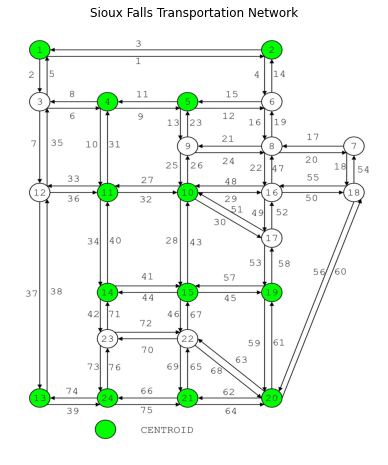

In [23]:
#-------- Part 3: Display network image ---------
img = Image.open("Input/Sioux-Falls-Network.jpg")
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Sioux Falls Transportation Network")
plt.show()

In [32]:
# --------- Part 4: Optimisation Problem ---------
nodes = sorted(set(network_df['From']).union(network_df['To']))
demand = dict(zip(demand_df['Node'], demand_df['EV demand']))

# Build symmetric distance matrix
dist_matrix = {(row['From'], row['To']): row['Distance'] for _, row in network_df.iterrows()}
for i, j in list(dist_matrix):
    dist_matrix[(j, i)] = dist_matrix[(i, j)]

# Parameters
coverage_radius = 20
max_stations = 5
station_cost = 1000
per_km_cost = 2

model = LpProblem("EVCS_Operational_Cost_Minimisation", LpMinimize)
x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in nodes}
y = {(i, j): LpVariable(f"y_{i}_{j}", lowBound=0, cat=LpContinuous)
     for i in nodes for j in nodes if (i, j) in dist_matrix and dist_matrix[i, j] <= coverage_radius}

model += (
    lpSum(x[j] * station_cost for j in nodes) +
    lpSum(y[i, j] * dist_matrix[i, j] * per_km_cost for (i, j) in y)
)

for i in nodes:
    if i in demand:
        model += lpSum(y[i, j] for j in nodes if (i, j) in y) == demand[i]

for (i, j) in y:
    model += y[i, j] <= demand.get(i, 0) * x[j]

model += lpSum(x[j] for j in nodes) <= max_stations

model.solve(PULP_CBC_CMD(msg=1))

selected_stations = [j for j in nodes if x[j].varValue > 0.5]
assignments = [(i, j, y[i, j].varValue) for (i, j) in y if y[i, j].varValue > 0.01]

print("\nSelected EVCS Locations:")
print(selected_stations)

#print("\nDemand Assignments:")
#for i, j, amount in assignments:
 #   print(f"  Node {i} assigned {amount:.1f} units to Station {j}")


Selected EVCS Locations:
[3, 8, 17, 19, 23, 24]
